In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from itertools import product as myzip
from random import shuffle

In [159]:
my_path = 'D:\s4353631\ISIC2018_'
datasets = {'train': [0, .7],
            'val': [.7, .9],
            'test': [.9, 1]}

x_paths = glob.glob(my_path + 'x' + '/*.jpg')
shuffle(x_paths)
labels = [i[-11:-4] for i in x_paths]

orig_shapes = []
for i in x_paths:
    i = tf.io.read_file(i)
    i = tf.io.decode_png(i)
    orig_shapes.append(tuple(i.shape[:-1]))

data_dict = {}

for i in datasets.keys():
    lower_bound = int(datasets[i][0] * len(labels))
    upper_bound = int(datasets[i][1] * len(labels))

    data_dict[i] = {'labels': labels[lower_bound:upper_bound],
                    'orig_shapes': orig_shapes[lower_bound:upper_bound],
                    'quantity': upper_bound - lower_bound}

In [202]:
def data_generator(dataset):
    i = 0

    while i < data_dict[dataset]['quantity']:
        label = data_dict[dataset]['labels'][i]
        
        x = tf.io.read_file('D:\s4353631\ISIC2018_x\ISIC_' + str(label) + '.jpg')
        x = tf.io.decode_jpeg(x)

        y = tf.io.read_file('D:\s4353631\ISIC2018_y\ISIC_' + str(label) + '_segmentation.png')
        y = tf.io.decode_png(y)

        x, y = [tf.cast(i, tf.float32) / 255 for i in (x, y)]
        x, y = [tf.image.resize(i, [200, 200]) for i in (x, y)]
        x, y = [tf.reshape(i, [-1, 200, 200]) for i in (x, y)] 

        y = tf.math.round(y)
                
        i += 1
        
        yield x, y
        
    print(i)

In [203]:
for i in datasets.keys():
    data_dict[i]['dset'] = tf.data.Dataset.from_generator(
        lambda: data_generator(i),
        (tf.float32, tf.float32),
        (tf.TensorShape([3, 200, 200]), tf.TensorShape([1, 200, 200])))

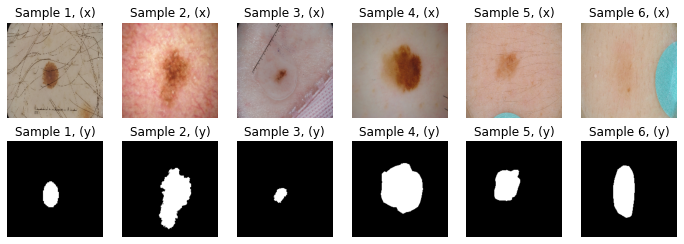

In [204]:
x_sample, y_sample = next(iter(data_dict['train']['dset'].batch(6)))

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))
labels = ['x', 'y']

for i in range(6):
    ax[0][i].imshow(tf.reshape(x_sample[i], [200, 200, 3]))
    ax[0][i].axis('off')
    ax[0][i].set_title('Sample ' + str(i + 1) + ', (x)')
    
    ax[1][i].imshow(tf.reshape(y_sample[i], [200, 200]).numpy(), cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title('Sample ' + str(i + 1) + ', (y)')
    
plt.show()